In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
import math

In [3]:
# read the respective files from these locations
#data_file_training='/data-restricted/PEM/L0162_20200909T0001_20201201T1230.csv'
data_file_training='/data/external/PEM/L0162_20200909T0001_20201201T1230.csv'
df = pd.read_csv(data_file_training)
print(df.shape)
print(list(df.columns))

(66331, 46)
['Timestamp', 'BRNDMD', 'WFPILM', 'F_FARFLI', 'F_FARFLO', 'F_FARFL', 'F_W2', 'F_WA36', 'F_WB3Q', 'F_WF36DMD', 'P2SEL', 'PS3SEL', 'T2SEL', 'T3SEL', 'TFLCYCS', 'TFLPDFS', 'TFLIDFS', 'TFLODFS', 'WFINRM', 'WFOTRM', 'WFQPERRCOR', 'A90RH', 'F_WAFL', 'NGGSEL', 'PX36SEL', 'PX36AVAL', 'PX36BVAL', 'NPTSEL', 'NPTREF', 'DWB36PCT', 'REGULATOR', 'T48SEL', 'CDPSEL', 'T8SEL', 'P48SEL', 'LHVSEL', 'SGSEL', 'NOX_HMI', 'CO_HMI', 'O2_HMI', 'VLVFBKG_06', 'EMISSIONS_SS', 'SSFILTER', 'F_WB3', 'NOX15', 'CO15']


In [4]:
df['DateTime']=pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H:%M')
print(df['DateTime'].min(),df['DateTime'].max()) 
#df[['DateTime','Timestamp']].tail()

2020-09-09 00:01:00 2020-12-01 12:30:00


In [6]:
#df.tail(4)

In [5]:
print(df['EMISSIONS_SS'].count())
df['EMISSIONS_SS'].value_counts()

16130


1.0    8597
0.0    7533
Name: EMISSIONS_SS, dtype: int64

## Data points with 'EMISSIONS_SS'==1.0

In [6]:
df1=df.copy()
df=df[df['EMISSIONS_SS']==1.0]
print(df.shape)

(8597, 47)


In [7]:
cols_with_NaNs=df.columns[df.isnull().any()].tolist()
print(cols_with_NaNs)
df_NaNs=df[cols_with_NaNs]
#df_NaNs.describe()
percent_missing=df_NaNs.isnull().sum() * 100/len(df_NaNs)
percent_missing

['PX36AVAL', 'PX36BVAL']


PX36AVAL    24.531813
PX36BVAL    24.531813
dtype: float64

In [8]:
df=df.set_index('DateTime')
df.head(3)

,Timestamp,BRNDMD,WFPILM,F_FARFLI,F_FARFLO,F_FARFL,F_W2,F_WA36,F_WB3Q,F_WF36DMD,...,SGSEL,NOX_HMI,CO_HMI,O2_HMI,VLVFBKG_06,EMISSIONS_SS,SSFILTER,F_WB3,NOX15,CO15
DateTime,,,,,,,,,,,,,,,,,,,,,
2020-10-15 11:34:00,15/10/2020 11:34,9,2472.353760,0.044216,0.040155,0.042101,75.424530,52.194382,0.075633,3192.609375,...,0.585581,0.452748,-0.143395,20.894999,0,1.0,0.0,5.704617,48.977804,48.977804
2020-10-15 11:35:00,15/10/2020 11:35,9,2481.855225,0.044298,0.040078,0.042159,75.497154,52.302616,0.078339,3200.897217,...,0.585652,0.330052,-0.235410,20.896107,0,1.0,0.0,5.914394,36.438830,36.438830
2020-10-15 11:36:00,15/10/2020 11:36,9,2621.278809,0.043893,0.039891,0.041922,77.976486,54.344658,0.069924,3317.199463,...,0.585691,0.268486,-0.012052,20.899307,0,1.0,0.0,5.452399,31.513235,31.513235


In [9]:
print(len(df[df['PX36AVAL'].isnull()].index.tolist()),len(df[df['PX36AVAL'].isnull()].index.tolist()))

2109 2109


In [10]:
df[df['PX36AVAL'].isnull()].index.tolist()

[Timestamp('2020-10-23 18:35:00'),
 Timestamp('2020-10-23 18:36:00'),
 Timestamp('2020-10-23 18:37:00'),
 Timestamp('2020-10-23 18:38:00'),
 Timestamp('2020-10-23 18:39:00'),
 Timestamp('2020-10-23 18:40:00'),
 Timestamp('2020-10-23 18:41:00'),
 Timestamp('2020-10-23 18:42:00'),
 Timestamp('2020-10-23 18:43:00'),
 Timestamp('2020-10-23 18:44:00'),
 Timestamp('2020-10-23 18:45:00'),
 Timestamp('2020-10-23 18:46:00'),
 Timestamp('2020-10-23 18:47:00'),
 Timestamp('2020-10-23 18:48:00'),
 Timestamp('2020-10-23 18:51:00'),
 Timestamp('2020-10-23 18:52:00'),
 Timestamp('2020-10-23 18:53:00'),
 Timestamp('2020-10-23 18:54:00'),
 Timestamp('2020-10-23 18:55:00'),
 Timestamp('2020-10-23 18:56:00'),
 Timestamp('2020-10-23 18:57:00'),
 Timestamp('2020-10-23 18:58:00'),
 Timestamp('2020-10-23 19:32:00'),
 Timestamp('2020-10-23 19:33:00'),
 Timestamp('2020-10-23 19:34:00'),
 Timestamp('2020-10-23 19:35:00'),
 Timestamp('2020-10-23 19:36:00'),
 Timestamp('2020-10-23 19:37:00'),
 Timestamp('2020-10-

array([<AxesSubplot:xlabel='DateTime'>, <AxesSubplot:xlabel='DateTime'>,
       <AxesSubplot:xlabel='DateTime'>, <AxesSubplot:xlabel='DateTime'>],
      dtype=object)

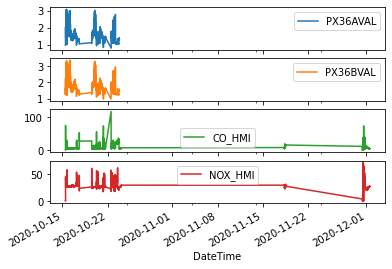

In [11]:
df[['PX36AVAL','PX36BVAL','CO_HMI','NOX_HMI']].plot(subplots=True)

In [ ]:
#df.drop(['NOX15','CO15'],axis=1,inplace=True)

In [12]:
data1=df.copy()
data1['PX36AVAL']=data1['PX36AVAL'].interpolate(method='linear')
data1['PX36BVAL']=data1['PX36BVAL'].interpolate(method='linear')

In [38]:
#data1[cols_with_NaNs].describe() #better

In [ ]:
#create a baseline model

In [13]:
print(list(data1.columns))

['Timestamp', 'BRNDMD', 'WFPILM', 'F_FARFLI', 'F_FARFLO', 'F_FARFL', 'F_W2', 'F_WA36', 'F_WB3Q', 'F_WF36DMD', 'P2SEL', 'PS3SEL', 'T2SEL', 'T3SEL', 'TFLCYCS', 'TFLPDFS', 'TFLIDFS', 'TFLODFS', 'WFINRM', 'WFOTRM', 'WFQPERRCOR', 'A90RH', 'F_WAFL', 'NGGSEL', 'PX36SEL', 'PX36AVAL', 'PX36BVAL', 'NPTSEL', 'NPTREF', 'DWB36PCT', 'REGULATOR', 'T48SEL', 'CDPSEL', 'T8SEL', 'P48SEL', 'LHVSEL', 'SGSEL', 'NOX_HMI', 'CO_HMI', 'O2_HMI', 'VLVFBKG_06', 'EMISSIONS_SS', 'SSFILTER', 'F_WB3', 'NOX15', 'CO15']


In [20]:

#right now no need
data1.drop(['NOX15', 'CO15','Timestamp'],axis=1,inplace=True)



In [21]:
# will split the data to 70:30 for training and testing
split=int(0.70*len(data1))
split

6017

In [22]:
train_df,test_df=data1[:split],data1[split:]
print(train_df.shape,test_df.shape)
OUTPUT_COLUMNS=['NOX_HMI','CO_HMI']
train_X=train_df.drop(OUTPUT_COLUMNS,axis=1)
train_y=train_df[OUTPUT_COLUMNS]
test_X=test_df.drop(OUTPUT_COLUMNS,axis=1)
test_y=test_df[OUTPUT_COLUMNS]
print(train_X.shape,train_y.shape,test_X.shape,test_y.shape)

(6017, 43) (2580, 43)
(6017, 41) (6017, 2) (2580, 41) (2580, 2)


In [16]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())
tf.config.list_physical_devices()


2021-08-26 05:12:34.623045: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


True


2021-08-26 05:12:36.094603: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2021-08-26 05:12:36.213421: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:8a:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-08-26 05:12:36.213471: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-26 05:12:36.219417: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-26 05:12:36.219492: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-08-26 05:12:36.222186: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2021-08-26 05:12:36.222537: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcura

In [16]:
train_y.head(2)

,NOX_HMI,CO_HMI
DateTime,,
2020-10-15 11:34:00,0.452748,-0.143395
2020-10-15 11:35:00,0.330052,-0.235410


In [17]:
test_y.head(2)

,NOX_HMI,CO_HMI
DateTime,,
2020-10-22 23:57:00,22.594032,14.375687
2020-10-23 00:06:00,22.335321,15.874600


### Grid Search XGB

In [ ]:
#Randomized Search results are better 
# less parameters should be given in search


In [18]:
import time
params={'n_estimators':[100,300,500,700],
       'min_child_weight':[1,5,9],
       'subsample':[i/10.0 for i in range(6,10)],
        'colsample_bytree':[i/10.0 for i in range(6,10)],
        'max_depth':[2,4,8],
        'objective':['reg:squarederror'],
        'booster':['gbtree'],
        'eval_metric':['rmse'],
        'learning_rate':[1/10 for i in range(1,9)],
       }
        
reg=xgb.XGBRegressor(tree_method='gpu_hist',gpu_id=0)


gsc=GridSearchCV(estimator=reg,param_grid=params,
                                 cv=3,scoring='neg_mean_squared_error')

start=time.time()
grid_search_result_NOX=gsc.fit(train_X,train_y['NOX_HMI'])

print('GridSearchCV took %.2f seconds' % ((time.time()-start)))


GridSearchCV took 16285.18 seconds


In [21]:
16285/3600 #4.5 hours

4.523611111111111

In [19]:
grid_CV_NOX_HMI=grid_search_result_NOX.best_estimator_
predictions_GS_NOX=grid_CV_NOX_HMI.predict(test_X)

print('Root_mean_squared_error_test set_NOX_gsxgb',math.sqrt(mean_squared_error(test_y['NOX_HMI'],predictions_GS_NOX)))
print('R2 Score_test set_NOX_gsxgb',r2_score(test_y['NOX_HMI'],predictions_GS_NOX))


Root_mean_squared_error_test set_NOX_gsxgb 4.398782121038349
R2 Score_test set_NOX_gsxgb 0.5643753857960357


In [20]:
grid_CV_NOX_HMI

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eval_metric='rmse',
             gamma=0, gpu_id=0, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=80,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.9, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

In [22]:

import time
params={'n_estimators':[100,300,500,700],
       'min_child_weight':[1,5,9],
       'subsample':[i/10.0 for i in range(6,10)],
        'colsample_bytree':[i/10.0 for i in range(6,10)],
        'max_depth':[2,4,8],
        'objective':['reg:squarederror'],
        'booster':['gbtree'],
        'eval_metric':['rmse'],
        'learning_rate':[1/10 for i in range(1,9)],
       }
        
reg=xgb.XGBRegressor(tree_method='gpu_hist',gpu_id=0)


gsc=GridSearchCV(estimator=reg,param_grid=params,
                                 cv=3,scoring='neg_mean_squared_error')

start=time.time()
grid_search_result_CO=gsc.fit(train_X,train_y['CO_HMI'])

print('GridSearchCV took %.2f seconds' % ((time.time()-start)))
#3 hours to run 13557 

GridSearchCV took 16158.29 seconds


In [23]:
best_params_Grid_search_CO_HMI=grid_search_result_CO.best_estimator_
predictions_GS_CO=best_params_Grid_search_CO_HMI.predict(test_X)

print('Root_mean_squared_error_test set_CO_gsxgb',math.sqrt(mean_squared_error(test_y['CO_HMI'],predictions_GS_CO)))
print('R2 Score_test set_CO_gsxgb',r2_score(test_y['CO_HMI'],predictions_GS_CO))

Root_mean_squared_error_test set_CO_gsxgb 4.983352625252082
R2 Score_test set_CO_gsxgb 0.3743054860902729


In [24]:
best_params_Grid_search_CO_HMI

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, eval_metric='rmse',
             gamma=0, gpu_id=0, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=9, missing=nan,
             monotone_constraints='()', n_estimators=700, n_jobs=80,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.9, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

In [ ]:
_ = plot_importance(gridcv_xgb, height=1.5)

In [28]:
import time
# single output regressor CO_HMI predictions
params={'n_estimators':[100,300,500,700],
       'min_child_weight':[1,5,9],
       'gamma':[i/10.0 for i in range(3,6)],
        'subsample':[i/10.0 for i in range(6,11)],
        'colsample_bytree':[i/10.0 for i in range(6,11)],
        'max_depth':[2,4,8],
        'objective':['reg:squarederror'],
        'booster':['gbtree'],
        'eval_metric':['rmse'],
        'eta':[1/10 for i in range(1,9)],
       }
        
reg=xgb.XGBRegressor(tree_method='gpu_hist',gpu_id=0)
#multioutputregressor_xgb=MultiOutputRegressor(reg)
n_iter_search=1000
random_search=RandomizedSearchCV(reg,param_distributions=params,n_iter=n_iter_search,
                                 cv=5,scoring='neg_mean_squared_error')

start=time.time()
random_search.fit(train_X,train_y['CO_HMI'])
print('RandomizedSearchCV took %.2f seconds for %d candidates'
      'parameter settings' % ((time.time()-start),n_iter_search))

RandomizedSearchCV took 3020.19 seconds for 1000 candidatesparameter settings


In [29]:
best_regressor_CO=random_search.best_estimator_
CO_predictions_RSCV_XGB=best_regressor_CO.predict(test_X)

best_regressor_CO

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eta=0.1,
             eval_metric='rmse', gamma=0.4, gpu_id=0, importance_type='gain',
             interaction_constraints='', learning_rate=0.100000001,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=80,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.6, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

In [30]:
print('Root_mean_squared_error_test set_CO_HMI_RSearch_xgb',math.sqrt(mean_squared_error(test_y['CO_HMI'],CO_predictions_RSCV_XGB)))
print('R2 Score_test set_CO_HMI_RSearch_xgb',r2_score(test_y['CO_HMI'],CO_predictions_RSCV_XGB))

Root_mean_squared_error_test set_CO_HMI_RSearch_xgb 3.6953092422172618
R2 Score_test set_CO_HMI_RSearch_xgb 0.655950694828507


In [31]:
# single output regressor NOX_HMI
params={'n_estimators':[100,300,500,700],
       'min_child_weight':[1,5,9],
       'gamma':[i/10.0 for i in range(3,6)],
        'subsample':[i/10.0 for i in range(6,11)],
        'colsample_bytree':[i/10.0 for i in range(6,11)],
        'max_depth':[2,4,8],
        'objective':['reg:squarederror'],
        'booster':['gbtree'],
        'eval_metric':['rmse'],
        'eta':[1/10 for i in range(1,9)],
       }
        
reg=xgb.XGBRegressor(tree_method='gpu_hist',gpu_id=0)
#multioutputregressor_xgb=MultiOutputRegressor(reg)
n_iter_search=1000
random_search_NOX=RandomizedSearchCV(reg,param_distributions=params,n_iter=n_iter_search,
                                 cv=5,verbose=0,scoring='neg_mean_squared_error')

start=time.time()
random_search_NOX.fit(train_X,train_y['NOX_HMI'])
print('RandomizedSearchCV took %.2f seconds for %d candidates' 
      'parameter settings' % ((time.time()-start),n_iter_search))

RandomizedSearchCV took 2735.48 seconds for 1000 candidatesparameter settings


In [32]:
best_regressor_NOX=random_search_NOX.best_estimator_
NOX_predictions_RSCV_XGB=best_regressor_NOX.predict(test_X)

best_regressor_NOX

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1,
             eval_metric='rmse', gamma=0.4, gpu_id=0, importance_type='gain',
             interaction_constraints='', learning_rate=0.100000001,
             max_delta_step=0, max_depth=2, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=700, n_jobs=80,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.6, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

In [33]:
print('Root_mean_squared_error_test set_NOX_HMI_RSearch_xgb',math.sqrt(mean_squared_error(test_y['NOX_HMI'],NOX_predictions_RSCV_XGB)))
print('R2 Score_test set_NOX_HMI_RSearch_xgb',r2_score(test_y['NOX_HMI'],NOX_predictions_RSCV_XGB))

Root_mean_squared_error_test set_NOX_HMI_RSearch_xgb 4.107939933377347
R2 Score_test set_NOX_HMI_RSearch_xgb 0.6200769196068889
